In [72]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


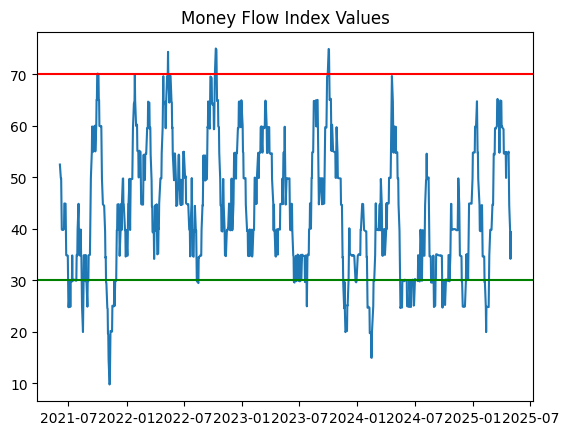

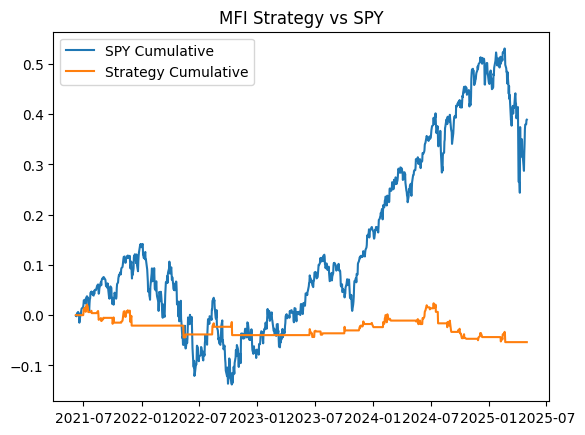

In [73]:
TICKER = 'SPY'
MFI_LENGTH = 20
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_MFI(df, length=MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = (100 / (1 + mfr))


    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    # plot the strategy returns

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title(F'MFI Strategy vs {TICKER}');

    return df

def main():

    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()